In [185]:
import igraph as ig
from igraph import Graph

class DBGraph:
    newid = 0
    k = 4 # we need to know the k-mer size (note: the length of the sequence per node is k-1)
    igraph = None
    name = ""
    compacted = False
    sequence = ""
    def __init__(self, name="", k=4):
        self.name = name
        self.k = k
        self.igraph = Graph(directed=True)    
        
    def vcount(self):
        return self.igraph.vcount()
    
    def add(self, s1, s2):
        if self.compacted:
            raise Exception("New nodes cannot be add to a compacted graph.")
        n1 = n2 = None
        try:
            n1 = self.igraph.vs.find(sequence=s1)     
        except:
            self.igraph.add_vertices(1)
            n1 = self.igraph.vs[self.newid]
            n1["label"] = n1["name"] = n1["sequence"] = s1
            n1['id'] = n1.index
            n1['visited'] = False
            n1['compacted'] = False
            n1['coverage'] = 1 ## minimum coverage, for plotting
            self.newid += 1            
        try:
            n2 = self.igraph.vs.find(sequence=s2)
        except:            
            self.igraph.add_vertices(1)
            n2 = self.igraph.vs[self.newid]
            n2["label"] =  n2["name"] = n2["sequence"] = s2
            n2['id'] = n2.index
            n2['visited'] = False
            n2['compacted'] = False
            n2['coverage'] = 1 ## minimum coverage, for plotting
            self.newid += 1
            
        assert n1 and n2, "Both nodes must exist at this point!"            
        i1 = n1.index
        i2 = n2.index
        print ("adding edge",i1, "-->" , i2)
        eid = None
        try: # the edge could be there already
            eid = self.igraph.get_eid(i1,i2)
            self.igraph.es[eid]["coverage"] += 1 ## in a true DeBrujn Graph the edges carry the multiplicity!
        except: # the edge is new
            self.igraph.add_edges([(i1,i2)])
            eid = self.igraph.get_eid(i1,i2)
            self.igraph.es[eid]["coverage"] = 1 
    
    def add_kmer(self,kmer):
        assert len(kmer) == self.k, "kmer sequence must have length k" 
        self.add(kmer[0:self.k-1], kmer[1:self.k])
        
            

    def get_node0(self):
        return Node(graph=self, id=0)
    
    def get_start_nodes(self):
        ret = []
        nset = self.igraph.vs.select(_indegree = 0)
        for n in nset:
            if not n['visited']:
                ret.append(Node(graph = self, id = n.index))
        return(ret)
    
    def compact(self):
        if self.compacted:
            raise Exception("Compaction can only be run once per graph")
        self.compacted = True
        ## look for simple 0 start nodes first
        ## only nodes with outdegree can be compacted        
        # for ni in nset0: print(ni["name"])
        i = 0
        # update set of not yet compacted nodes after each iteration
        while True: # this needs to be done this way, otherwise the set is not updated correctly    
            nset0 = self.igraph.vs.select(_outdegree_eq = 1, compacted = False)
            print (i,':', len(nset0))
            if len(nset0) < 1:          
                break
            n = nset0[0]
            i += 1
            print("Start compacting: ", n['name'])         
            assert not n['compacted'], "We hit an already compacted node!" # this should never happen because of select statement
            first_time = True
            # don't take this node again
            # we are going to simply delete the neighbors, there is only one dircet neighbor
            # but we also need to check if the next node is balanced
            n['compacted'] = True # mark this node as compacted, so it won't come up again
            n['sum'] = 0 # compacted nodes store their coverage themselves, sum of coverages
            n['dist'] = 0 # distance forward to next "junction" ahead
            ## This is the actual compaction for node n
            while True: 
                ## exit condition: we don't have exactly 1 successor, or the next node has 
                ## multiple incoming nodes
                if (n.outdegree() != 1 or n.successors()[0].indegree() != 1):
                    break                
                succ = n.successors()[0] # node is linear, so we are sure
                ## Only the very first node in our path needs to keep the full k-mer, that is a node with in_degree 0
                ## All other need to be clipped now
                if n.indegree() > 0 and first_time: 
                    # otherwise we would artificially prolong the sequence
                    n['sequence'] = n['sequence'][self.k-2] # get only last letter
                    first_time = False # but only once, otherwise we'd chop off the whole sequence
                    
                print("compacting", n['name'], '-->', succ)
                eid = self.igraph.get_eid(n.index, succ.index) # geet the edge id
                ## add edges to all succ.successors to this node
                for s in succ.successors():
                    self.igraph.add_edges([(n.index,s.index)]) ## add a new edge, 
                    new_eid = self.igraph.get_eid(n.index, s.index) ## and get the index of the edge we just made
                    ## we need to copy the coverage attribute over, 
                    ## so get the edge connecting 
                    ## successor to its next successor
                    succ_eid = self.igraph.get_eid(succ.index, s.index)
                    self.igraph.es[new_eid]['coverage'] = self.igraph.es[succ_eid]['coverage']  # copy coverage            
                ## get the successors single character and add to node sequence
                if succ["compacted"]:
                    ## add the sequence of the compacted node, it is already compacted
                    n["sequence"] += succ["sequence"]
                    n["sum"] += succ["sum"]
                    n['dist'] += succ['dist']   
                else:
                    n["sequence"] += succ["sequence"][self.k - 2]
                    n['sum'] += self.igraph.es[eid]['coverage'] # here the coverage is in the edge
                    n['dist'] += 1 # now we have made only a single step                   
                n["name"] = n["label"] = n["sequence"]    
                ## now delete the successor and the edge
                eid = self.igraph.get_eid(n.index, succ.index)
                self.igraph.delete_edges(eid)
                self.igraph.delete_vertices(succ.index)
                
        ## Now the compaction is complete, but we still have sum and dist per node, but not coverage, so we need to update
        ## the compacted nodes in a last sweep over all compacted nodes
        for n in self.igraph.vs.select(compacted = True):
            if (n['dist'] == 0): 
                n['coverage'] = 1
                n['compacted'] = False ## these nodes were not really compacted, there were just marked 
            else:
                n['coverage'] = n['sum']/n['dist']
        
            
    def plot(self):
        visual_style = {}
        visual_style["edge_width"] = [2 * int(coverage) for coverage in self.igraph.es["coverage"]]
        return(ig.plot(self.igraph, bbox=(0, 0, 200, 200), **visual_style))
        
    def viz(self):
        layout = self.igraph.layout("kk")
        color_dict = {True: "lightgreen", False: "tomato"}
        colors = [color_dict[c] for c in self.igraph.vs["compacted"]]
        shapes = []
        visual_style = {}
        visual_style["edge_width"] = [0.5 * int(coverage) for coverage in self.igraph.es["coverage"]]
        visual_style["vertex_size"] = [20 * int(coverage) for coverage in self.igraph.vs["coverage"]]
        for s in self.igraph.vs.indegree():
            if s == 0:
                shapes.append("rectangle")
            else:
                shapes.append("circle")
        return(ig.plot(self.igraph, bbox=(0, 0, 400, 400), vertex_color=colors, 
                       vertex_shape=shapes, vertex_label_dist = -0.5, layout=layout, **visual_style ))

        
    def print(self):
        print(self.igraph)
        
    ### The gredy assembly is the simplest possible heuristics and works on the compacted graph
    ### With greedy bubble correction and at every junction, follow the path of highest coverage
    ### No variants will be detected this way
    ### Dangling short ends will be cut off if they are shorter than 2*k, and there is another 
    ### path > 2*k ahead, even if they have higher coverage 
    ### If a repeat (a node that has already been visited) is hit with distance < 2*k, the contig will be dropped 
    #   - get all start nodes, easy ones first until all nodes have been visited
    def greedy_assembly_depth_first(self):
        if not self.compacted:
            raise Exception("Assembly requires the graph to be compacted, run compact() on your graph first.")        
    
class Node:
    id = 0
    graph = None
    inode = None
    def __init__(self, graph, id=None, sequence=None):
        self.graph = graph
        if sequence:
            self.inode = graph.igraph.vs.find(sequence=sequence)
        else: 
            if id != None:
                self.inode = graph.igraph.vs[id]               
        self.id = self.inode['id']
        
    def indegree(self):
        return self.inode.indegree()
    
    def outdegree(self):
        return self.inode.outdegree()
    



adding edge 0 --> 0
adding edge 1 --> 2
adding edge 2 --> 3
adding edge 3 --> 4
adding edge 4 --> 5
adding edge 5 --> 6
adding edge 2 --> 7
adding edge 2 --> 7
adding edge 2 --> 7
adding edge 7 --> 8
adding edge 7 --> 8
adding edge 8 --> 9
adding edge 8 --> 9
adding edge 9 --> 6
adding edge 6 --> 10
IGRAPH DN-- 11 11 --
+ attr: compacted (v), coverage (v), id (v), label (v), name (v), sequence
  (v), visited (v), coverage (e)
+ edges (vertex names):
ttt->ttt, abb->bbb, bbb->bba, bba->bas, bas->asu, asu->suu, bbb->bbA,
bbA->bAs, bAs->Asu, Asu->suu, suu->uuu


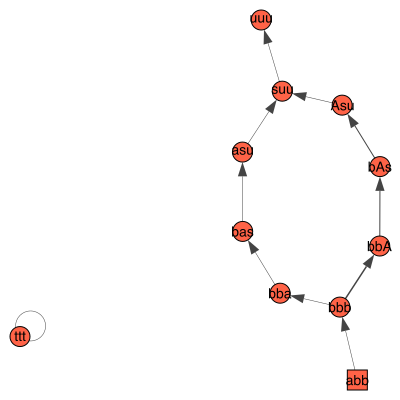

In [186]:
g = DBGraph('hey joe')

g.add_kmer('tttt')
## bubble graph
g.add('abb','bbb')
g.add('bbb','bba')
g.add('bba','bas')
g.add('bas','asu')
g.add('asu','suu')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbA','bAs')
g.add('bbA','bAs')
g.add('bAs','Asu')
g.add('bAs','Asu')
g.add('Asu','suu')
g.add('suu','uuu')

## alternative start and end nodes
## g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("XAT","ATG")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")


g.print()
g.viz()



0 : 8
Start compacting:  abb
compacting abb --> igraph.Vertex(<igraph.Graph object at 0x7f985887b130>, 1, {'label': 'bbb', 'name': 'bbb', 'sequence': 'bbb', 'id': 1, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
1 : 7
Start compacting:  bba
compacting bba --> igraph.Vertex(<igraph.Graph object at 0x7f985887b130>, 2, {'label': 'bas', 'name': 'bas', 'sequence': 'bas', 'id': 3, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
compacting as --> igraph.Vertex(<igraph.Graph object at 0x7f985887b130>, 2, {'label': 'asu', 'name': 'asu', 'sequence': 'asu', 'id': 4, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
2 : 4
Start compacting:  suu
compacting suu --> igraph.Vertex(<igraph.Graph object at 0x7f985887b130>, 6, {'label': 'uuu', 'name': 'uuu', 'sequence': 'uuu', 'id': 9, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
3 : 3
Start compacting:  bbA
compacting bb

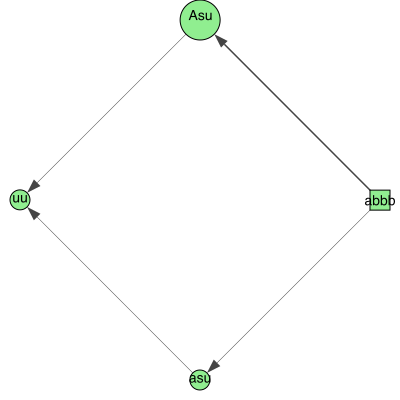

In [169]:
g.compact()
g.print()
g.viz()






adding edge 0 --> 1
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 2 --> 3
adding edge 2 --> 4
adding edge 5 --> 6
adding edge 5 --> 6
adding edge 6 --> 7
adding edge 8 --> 9
adding edge 9 --> 10
adding edge 10 --> 8
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 12
adding edge 11 --> 12
adding edge 12 --> 13
adding edge 13 --> 14
adding edge 14 --> 11


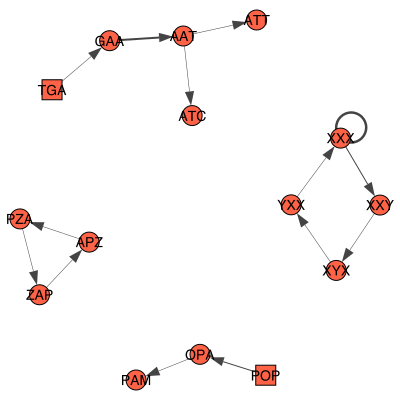

In [164]:
g = DBGraph('test more stuff')
g.add("TGA","GAA")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")

g.add("AAT","ATT")
g.add("AAT","ATC")

# short linear graph
g.add("POP","OPA")
g.add('POP','OPA')
g.add("OPA","PAM")

# cyclic
g.add("ZAP","APZ")
g.add("APZ","PZA")
g.add("PZA","ZAP")


## self repeat + cyclic graph
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXY")
g.add("XXX","XXY")

g.add("XXY","XYX")
g.add("XYX","YXX")
g.add("YXX","XXX")
g.viz()

0 : 10
Start compacting:  TGA
compacting TGA --> igraph.Vertex(<igraph.Graph object at 0x7f985885be50>, 1, {'label': 'GAA', 'name': 'GAA', 'sequence': 'GAA', 'id': 1, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
compacting TGAA --> igraph.Vertex(<igraph.Graph object at 0x7f985885be50>, 1, {'label': 'AAT', 'name': 'AAT', 'sequence': 'AAT', 'id': 2, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
1 : 8
Start compacting:  POP
compacting POP --> igraph.Vertex(<igraph.Graph object at 0x7f985885be50>, 4, {'label': 'OPA', 'name': 'OPA', 'sequence': 'OPA', 'id': 6, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
compacting POPA --> igraph.Vertex(<igraph.Graph object at 0x7f985885be50>, 4, {'label': 'PAM', 'name': 'PAM', 'sequence': 'PAM', 'id': 7, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
2 : 6
Start compacting:  ZAP
compacting ZAP --> igraph.Vertex(<igra

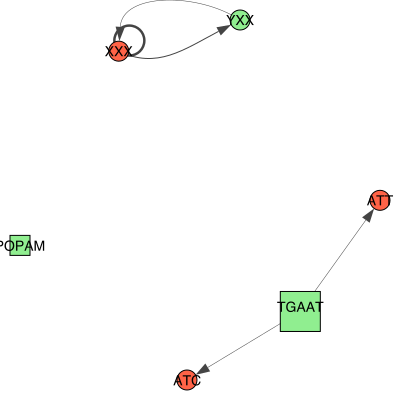

In [165]:
g.compact()
g.viz()